Install all needed libraries

In [1]:
!pip install pandas
!pip install sklearn
!pip install joblib
!pip install matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Data Cleaning and Preprocessing:


*   Load dataset (https://www.kaggle.com/datasets/abdallahwagih/books-dataset?resource=download)
*   Remove rows where description and category is not given
*   Keep only the first genre if multiple are present
*   Keep the most frequent genres only
*   Split the dataset into training and test set
*   Vectorize using TF-IDF



In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels

df = pd.read_csv("data.csv")
df_clean = df.dropna(subset=["description", "categories"]).copy()
df_clean["main_category"] = df_clean["categories"].apply(lambda x: x.split(";")[0].strip())

# leave top 10 most frequent genres
top_categories = df_clean["main_category"].value_counts().nlargest(10).index.tolist()
df_top10 = df_clean[df_clean["main_category"].isin(top_categories)]

# prepare features (X) and labels (y)
X = df_top10["description"]
y = df_top10["main_category"]

# encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# training 80% and test 20% sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# vectorize descriptions
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Models Training and Accuracy Computing

In [6]:
# Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)
y_pred_nb = model_nb.predict(X_test_vec)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)
y_pred_rf = rf_model.predict(X_test_vec)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Support Vector Machine (SVM)
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

Naive Bayes Accuracy: 0.5737704918032787
Logistic Regression Accuracy: 0.653551912568306
Random Forest Accuracy: 0.6644808743169399
SVM Accuracy: 0.7158469945355191


Classification Report for Naive Bayes

In [7]:
present_labels = unique_labels(y_test, y_pred_nb)
present_class_names = label_encoder.inverse_transform(present_labels)

report = classification_report(
    y_test, y_pred_nb,
    labels=present_labels,
    target_names=present_class_names,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()
top_f1 = report_df.sort_values(by="f1-score", ascending=False).head(10)

print("\nTop 10 genres by F1-score (Naive Bayes):")
print(top_f1)


Top 10 genres by F1-score (Naive Bayes):
                           precision    recall  f1-score    support
Fiction                     0.570796  1.000000  0.726761  516.00000
accuracy                    0.573770  0.573770  0.573770    0.57377
weighted avg                0.478722  0.573770  0.428156  915.00000
Literary Criticism          1.000000  0.120000  0.214286   25.00000
macro avg                   0.340413  0.119988  0.109364  915.00000
Juvenile Fiction            0.833333  0.047619  0.090090  105.00000
Philosophy                  1.000000  0.032258  0.062500   31.00000
Comics & Graphic Novels     0.000000  0.000000  0.000000   22.00000
Biography & Autobiography   0.000000  0.000000  0.000000   86.00000
History                     0.000000  0.000000  0.000000   56.00000


Confusion Matrix for Naive Bayes

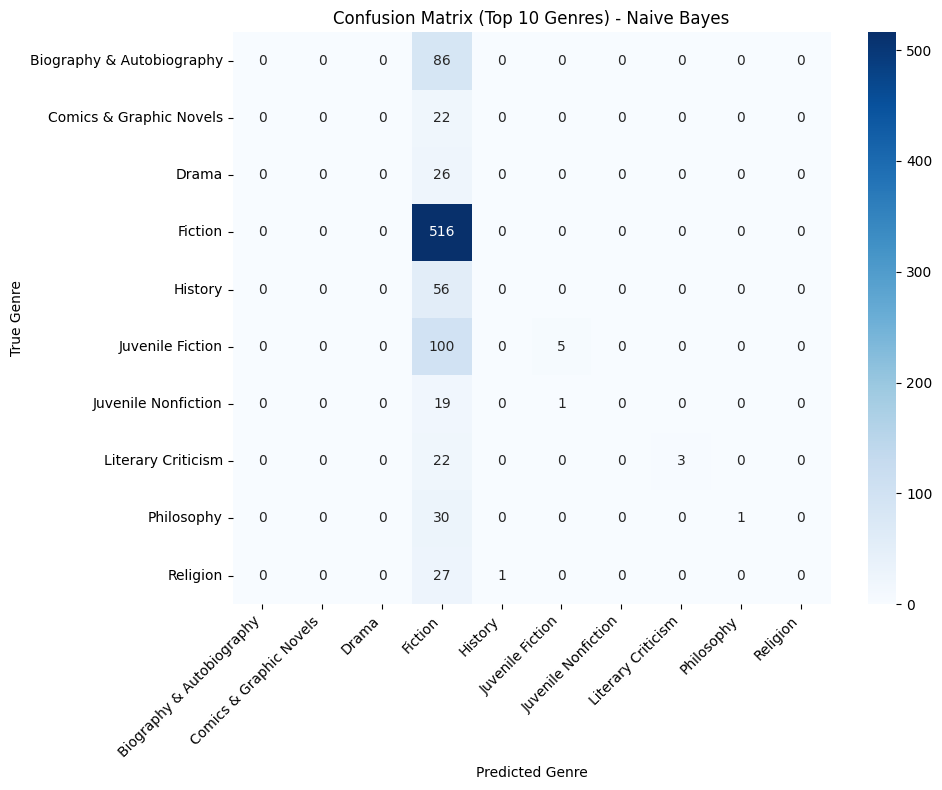

In [8]:
cm = confusion_matrix(y_test, y_pred_nb, labels=present_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names,
            yticklabels=present_class_names)
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.title("Confusion Matrix (Top 10 Genres) - Naive Bayes")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

F1-score Comparison


🔍 F1-score (macro) for all models:
Naive Bayes: 0.1094
Logistic Regression: 0.3246
Random Forest: 0.3633
SVM: 0.5003

🏆 Best model based on macro F1-score: SVM (0.5003)


<ipython-input-9-51e29b0c2fbf>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="viridis")


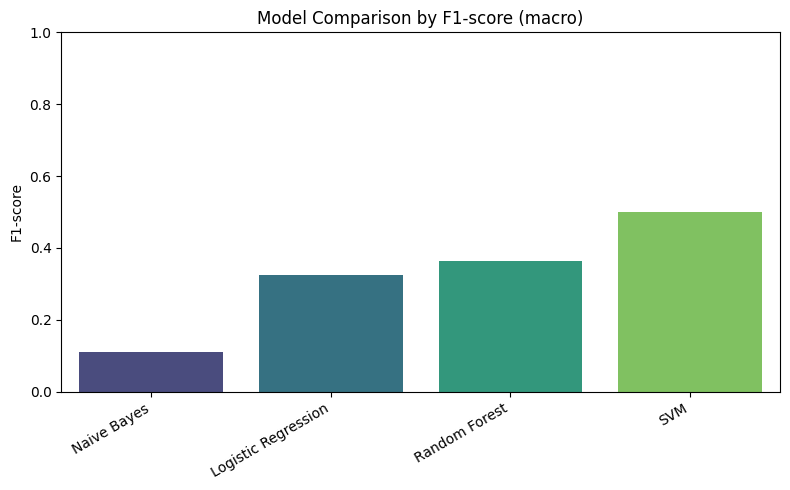


✅ All models and preprocessing objects saved successfully.


In [9]:
f1_scores = {
    "Naive Bayes": f1_score(y_test, y_pred_nb, average="macro", zero_division=0),
    "Logistic Regression": f1_score(y_test, y_pred_lr, average="macro", zero_division=0),
    "Random Forest": f1_score(y_test, y_pred_rf, average="macro", zero_division=0),
    "SVM": f1_score(y_test, y_pred_svm, average="macro", zero_division=0)
}
# Print F1-scores
print("\n🔍 F1-score (macro) for all models:")
for model_name, score in f1_scores.items():
    print(f"{model_name}: {score:.4f}")

# Find the best model
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_model_name]
print(f"\n🏆 Best model based on macro F1-score: {best_model_name} ({best_f1_score:.4f})")

# Plot F1-score comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="viridis")
plt.title("Model Comparison by F1-score (macro)")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# === Save all models and encoders ===
joblib.dump(model_nb, "genre_classifier_nb.pkl")
joblib.dump(log_reg, "genre_classifier_logreg.pkl")
joblib.dump(rf_model, "genre_classifier_rf.pkl")
joblib.dump(svm_model, "genre_classifier_svm.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("\n✅ All models and preprocessing objects saved successfully.")